최종수정일시. 21-05-19 (이해강)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
from math import ceil

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')

### 데이터 불러오기 및 결측치 처리

In [3]:
ndf = pd.read_excel('과제수정DB.xlsx',encoding='utf-8')
ndf['app_yn'].replace(np.nan, 'N', inplace=True)
ndf.dropna(axis=0, inplace=True)

### 새로운 컬럼 생성 및 타입 변환 (Feature Engineering)

In [4]:
# 유저별 결제건수 컬럼
u_ndf = ndf['USER'].value_counts().to_frame()
u_ndf.reset_index(inplace = True)
u_ndf.columns = ['USER','count']
ndf = pd.merge(ndf, u_ndf, how='left', left_on='USER', right_on='USER')

# 경과일 컬럼
ndf['Elapsed_day'] = ndf['order_date']-ndf['reg_date']
for i in range(len(ndf['Elapsed_day'])):
    ndf['Elapsed_day'].iloc[i] = str(ndf['Elapsed_day'].iloc[i]).split('days')[0]

# 가입 월, 일 컬럼
ndf['reg_Month'] = [k for k in ndf['reg_date'].dt.month]
ndf['reg_Day'] = [k for k in ndf['reg_date'].dt.day]

# 주문 월, 일 컬럼
ndf['order_Month'] = [k for k in ndf['order_date'].dt.month]
ndf['order_Day'] = [k for k in ndf['order_date'].dt.day]

# 'USER' 숫자형으로 변환
for i in range(len(ndf['USER'])):
    ndf['USER'].iloc[i] = ndf['USER'].iloc[i].split('a')[1]

# 'p_type' 숫자형으로 변환
for i in range(len(ndf['p_type'])):
    ndf['p_type'].iloc[i] = ndf['p_type'].iloc[i].split('days')[0]
    
ndf = ndf.astype({'USER':int, 'p_type':int, 'Elapsed_day':int})

# 범주형 컬럼 레이블인코딩하여 숫자형으로
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

ndf['brandnm'] = le.fit_transform(ndf['brandnm'])
ndf['sub_type'] = le.fit_transform(ndf['sub_type'])
ndf['app_yn'] = le.fit_transform(ndf['app_yn'])

# 불필요한 컬럼 삭제
ndf.drop(['reg_date','order_date','goodsnm'],axis=1,inplace=True)
ndf

,brandnm,USER,p_type,sub_type,app_yn,count,Elapsed_day,reg_Month,reg_Day,order_Month,order_Day
0,98,161237,7,1,1,1,406,12,6,1,15
1,83,1140859,4,3,0,3,13,1,2,1,15
2,67,1140859,4,0,0,3,13,1,2,1,15
3,67,1140859,4,4,0,3,13,1,2,1,15
4,44,1140740,7,3,1,1,14,1,1,1,15
...,...,...,...,...,...,...,...,...,...,...,...
1464,246,119721,7,1,1,1,691,4,10,3,1
1465,184,1146069,7,1,1,1,18,2,11,3,1
1466,42,1147848,7,4,1,1,1,2,28,3,1
1467,53,1147788,7,4,1,1,1,2,28,3,1


### KMeans 모델링 (4개의 군집으로 나누기)

In [26]:
# KMeans 모델링
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, max_iter=10000, random_state=42)
pred = model.fit_predict(ndf)

# 예측값과 데이터프레임 병합
pred = pd.DataFrame(pred)
pred.columns=['predict']
r = pd.concat([ndf,pred],axis=1)
r

,brandnm,USER,p_type,sub_type,app_yn,count,Elapsed_day,reg_Month,reg_Day,order_Month,order_Day,predict
0,98,161237,7,1,1,1,406,12,6,1,15,3
1,83,1140859,4,3,0,3,13,1,2,1,15,1
2,67,1140859,4,0,0,3,13,1,2,1,15,1
3,67,1140859,4,4,0,3,13,1,2,1,15,1
4,44,1140740,7,3,1,1,14,1,1,1,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1464,246,119721,7,1,1,1,691,4,10,3,1,0
1465,184,1146069,7,1,1,1,18,2,11,3,1,1
1466,42,1147848,7,4,1,1,1,2,28,3,1,1
1467,53,1147788,7,4,1,1,1,2,28,3,1,1


### 모델링 결과 시각화

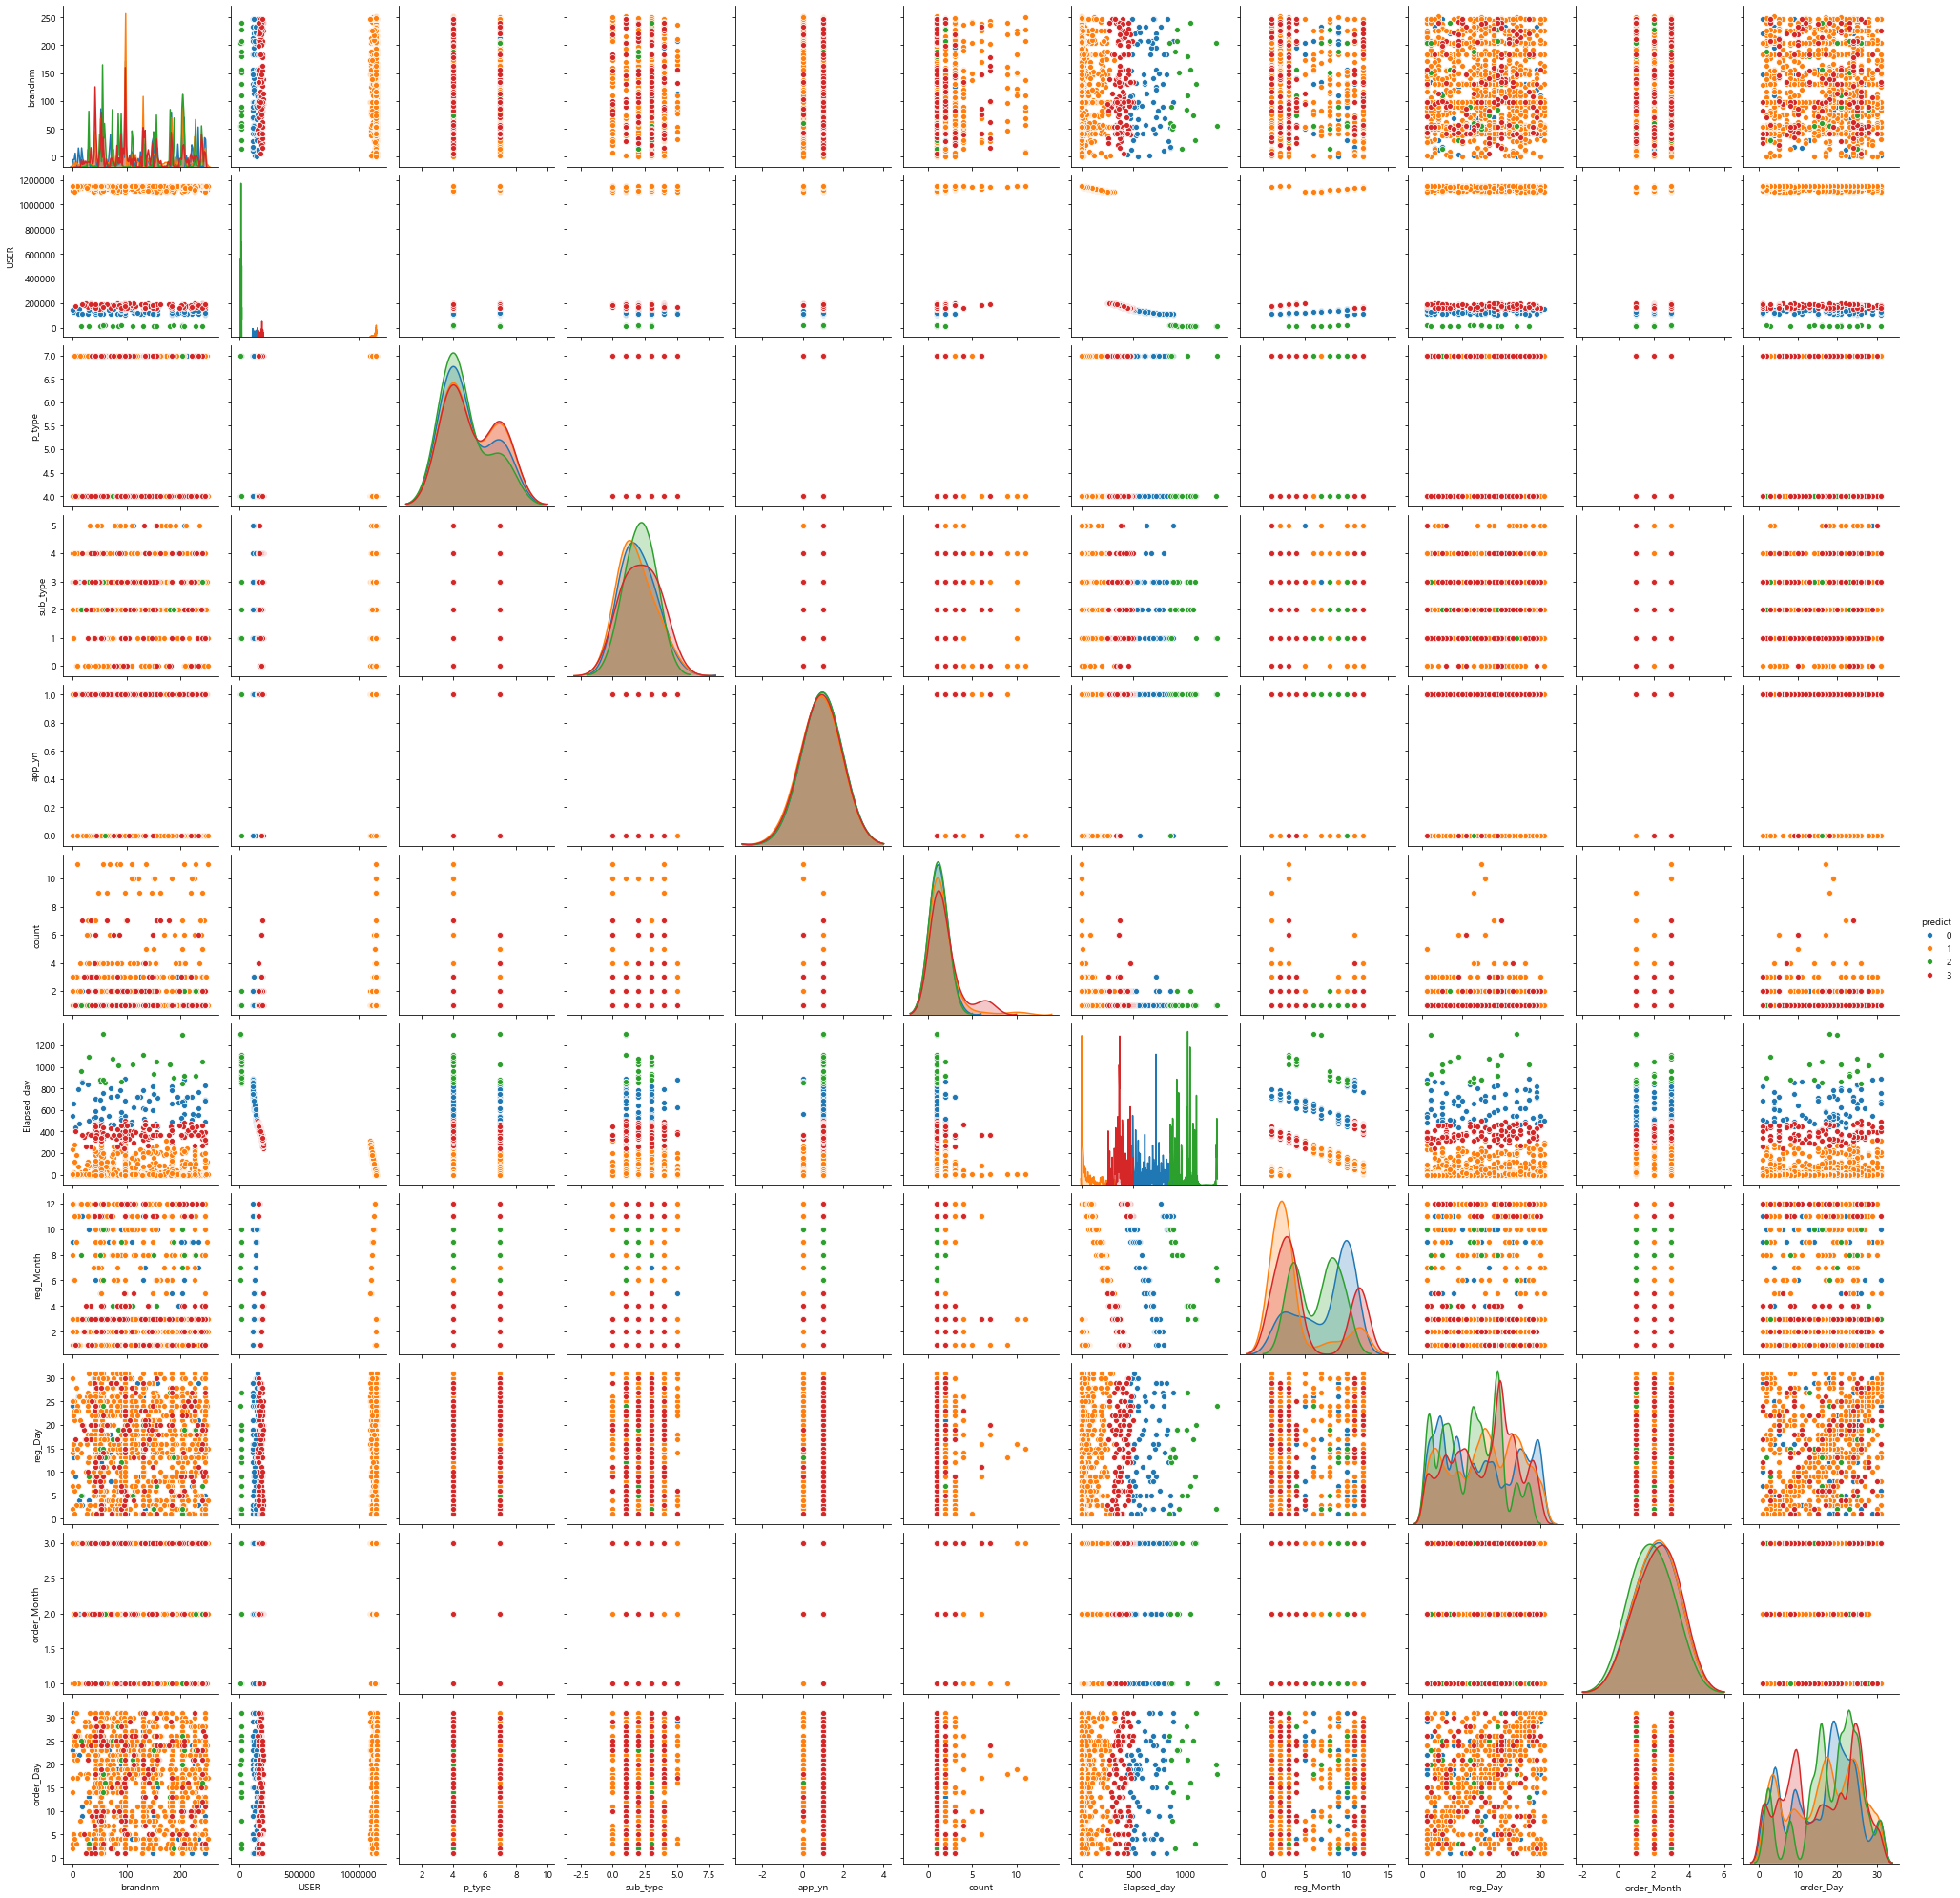

In [27]:
# 예측 데이터 시각화
sns.pairplot(r, hue='predict',diag_kws = { 'bw': 1})
plt.show()

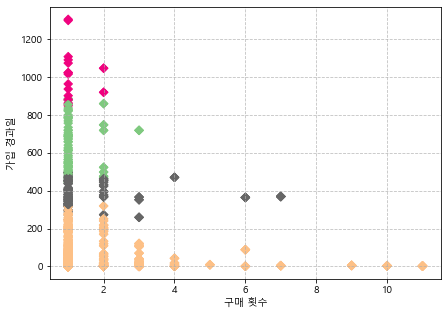

In [109]:
plt.figure(figsize=(7,5))
colors = np.random.rand(10)
plt.scatter(x=ndf['count'], y=ndf['Elapsed_day'], c=r['predict'], cmap='Accent', marker='D')
plt.xlabel('구매 횟수')
plt.ylabel('가입 경과일')
plt.grid(alpha=0.8, linestyle='--')

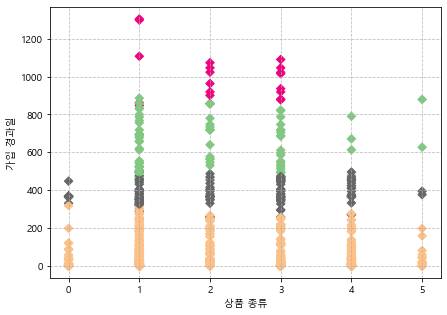

In [108]:
plt.figure(figsize=(7,5))
plt.scatter(x=ndf['sub_type'], y=ndf['Elapsed_day'], c=r['predict'], cmap='Accent', marker='D')
plt.xlabel('상품 종류')
plt.ylabel('가입 경과일')
plt.grid(alpha=0.8, linestyle='--')

#### 클러스터링 분석의 결과
1. 신규 유입 회원으로 구성된 군집일수록 다양한 브랜드를 렌탈하고 렌탈 횟수의 범위도 비교적 넓은 편으로 보인다. 또한 렌탈한 카테고리 종류도 고루 분포되어 있다.
2. 반대로 가입일이 오래된 회원으로 구성된 군집일수록 렌탈 횟수와 렌탈한 브랜드의 종류, 렌탈한 카테고리 종류가 적다.